### Run vanilla `scarlet` for ~5476 LSBG candidates at 0.02 < z < 0.04.

In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, display_rgb, SEG_CMAP
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

import unagi

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.convolution import convolve, Gaussian2DKernel


Bad key savefig.frameon in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc

In [3]:
from kuaizi.fit import ScarletFitter, fitting_obs_tigress

In [4]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/tigress/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.utils.set_matplotlib(style='default', usetex=False)

In [5]:
lsbg_cat = Table.read('/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Catalog/NSA/z002_004/nsa_cutout_cat_z002_004.fits')
print('# of LSBGs:', len(lsbg_cat))

# of LSBGs: 5576


In [6]:
# Imcomplete file
np.array([  462,  4081,  6161,  8176,  7406,  9498, 12637, 38550,
       40895, 38890, 36497, 42403, 47032, 48071, 48284,
       48689, 61669, 59005, 60514, 63338, 62688, 83009,
       84001, 87524, 88927, 85773, 88419, 89528]).shape
# real_fail: 46202, 84988

(28,)

In [7]:
lsbg = lsbg_cat[int(np.where(lsbg_cat['viz-id'] == 50509)[0][0])]

In [8]:
prefix = 'LSBG'
channels = 'griz'
index = lsbg['viz-id']

bright = (lsbg['mag_auto_i'] < 17.5)
print('Bright =', bright)

lsbg_coord = SkyCoord(ra=lsbg['ra'], dec=lsbg['dec'], unit='deg')
cutout = [fits.open(f"{lsbg['prefix']}_{band}.fits") for band in channels]
psf_list = [fits.open(f"{lsbg['prefix']}_{band}_psf.fits") for band in channels]

images = np.array([hdu[1].data for hdu in cutout])
# note: all bands share the same WCS here, but not necessarily true.
w = wcs.WCS(cutout[0][1].header)
weights = 1.0 / np.array([hdu[3].data for hdu in cutout])
weights[np.isinf(weights)] = 0.0
psf_pad = padding_PSF(psf_list)  # Padding PSF cutouts from HSC
psfs = scarlet.ImagePSF(np.array(psf_pad))
# saturation mask and interpolation mask from HSC S18A
sat_mask = np.array([sum(unagi.mask.Mask(
    hdu[2].data, data_release='s18a').extract(['INTRP', 'SAT'])) for hdu in cutout])
data = Data(images=images, weights=weights, masks=sat_mask,
            wcs=w, psfs=psfs, channels=channels)

Bright = False


In [11]:
fitter = ScarletFitter(method='wavelet', tigress=True, bright=bright,
                       starlet_thresh=0.3, min_grad=-0.02,
                       monotonic=True, bkg=True,
                       variance=0.015**2, 
                       scales=[0, 1, 2, 3, 4],
                       log_dir='./log/nsa_z002_004/', 
                       figure_dir='./Figure/nsa_z002_004/',
                       model_dir='./Model/nsa_z002_004/',
                       prefix='nsa', 
                       index=index, 
                       show_figure=True)
fitter.load_data(data, lsbg_coord)

  - Detect sources and make mask
    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    1 stars from Gaia are masked!
    Detected 85 objects
    1 stars from Gaia are masked!
    Detected 80 objects
    Detected 41 objects
  - Wavelet modeling with the following hyperparameters:
    min_grad = -0.02, starlet_thresh = 0.30 (contam_ratio = 0.03), 
     monotonic = True, variance = 0.00022, scales = [0, 1, 2, 3, 4].
    Added constant sky background
    Total number of sources: 2
  - Optimizing scarlet model...
    Optimizaiton: Succeed for e_rel = 0.0001 with 135 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 204 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0002 with 280 iterations! Try higher accuracy!
  - After 265 iterations, logL = 811216.14
    Elapsed time for fitting: 97.20 s
  - Components [0] are considered as the target galaxy.
  - Masking stars and other sources that are modeled, to deal with le

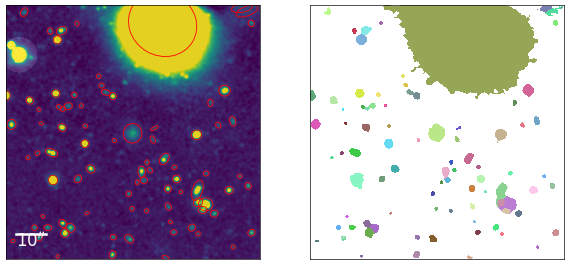

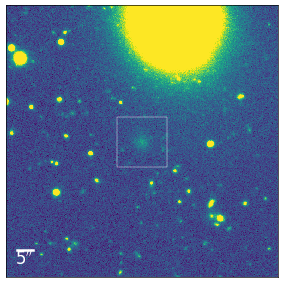

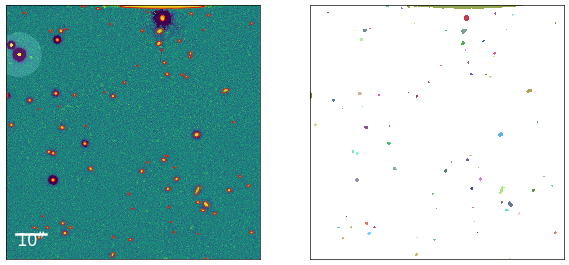

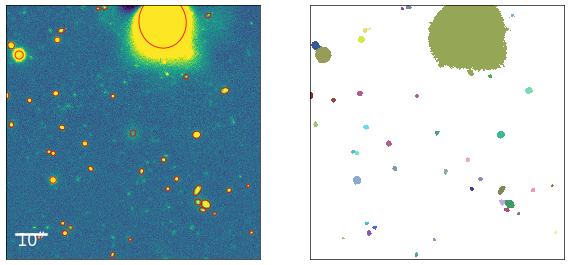

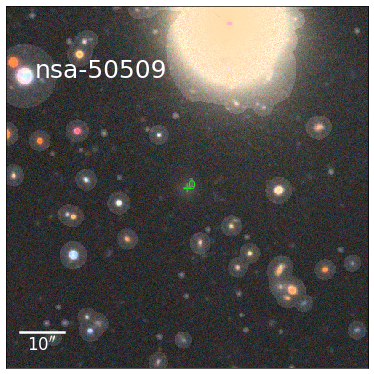

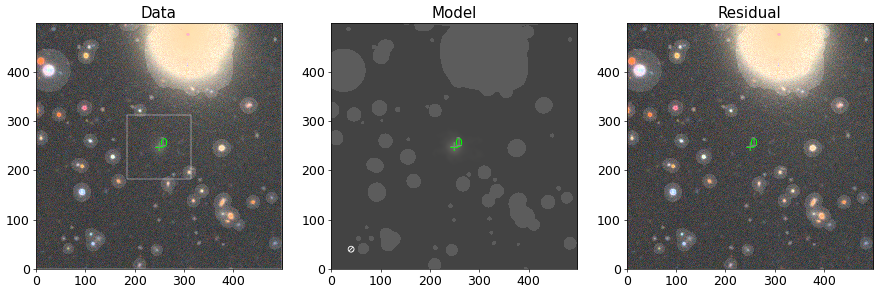

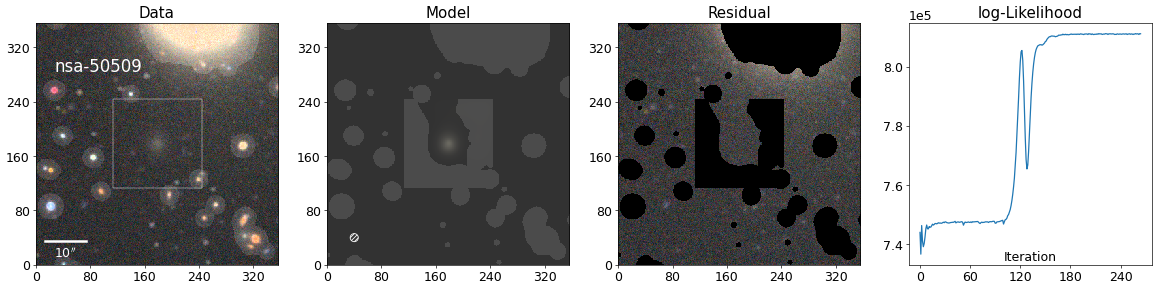

In [12]:
fitter.fit()

In [20]:
# Sky SB
-2.5 * np.log10(fitter.blend.sources[-1].get_model().mean(axis=(1, 2)) / 0.168**2) + 27

Parameter([27.96274705, 27.53355878, 27.29507997, 26.80693446])

In [13]:
# Sky SB
-2.5 * np.log10(fitter.blend.sources[-1].get_model().mean(axis=(1, 2)) / 0.168**2) + 27

Parameter([27.73296914, 27.23904644, 27.00345151, 26.623953  ])

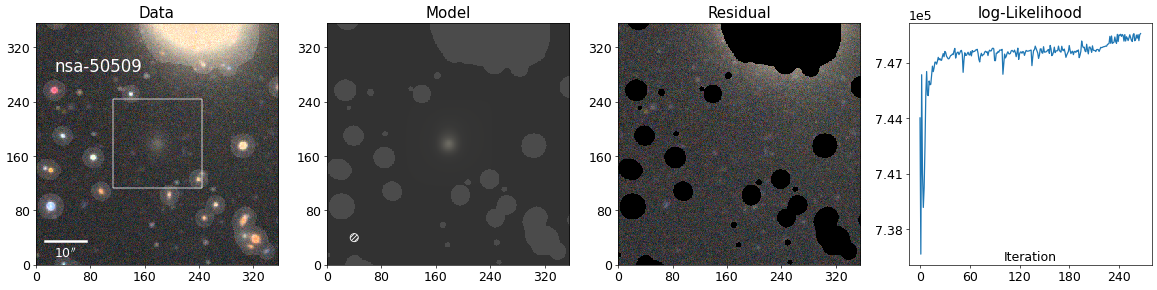

#### Step-by-step

In [11]:
fitter._first_gaia_search()

    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    1 stars from Gaia are masked!


In [12]:
# Set the weights of saturated star centers to zero
# In order to make the box size estimation more accurate.
temp = np.copy(fitter.data.masks)
for i in range(len(fitter.data.channels)):
    temp[i][~fitter.msk_star_ori.astype(bool)] = 0
    fitter.data.weights[i][temp[i].astype(bool)] = 0.0

    Detected 85 objects


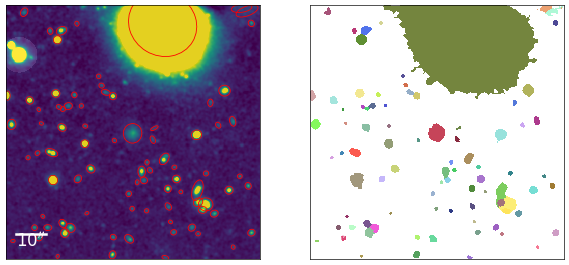

In [13]:
# Replace the vanilla detection with a convolved vanilla detection
first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.006

if fitter.method == 'wavelet':
    first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.002
        
fitter._first_detection(first_dblend_cont)

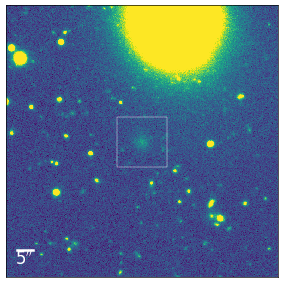

In [14]:
fitter._estimate_box(fitter.cen_obj)

In [15]:
fitter._mask_stars_outside_box()

    1 stars from Gaia are masked!


    Detected 80 objects


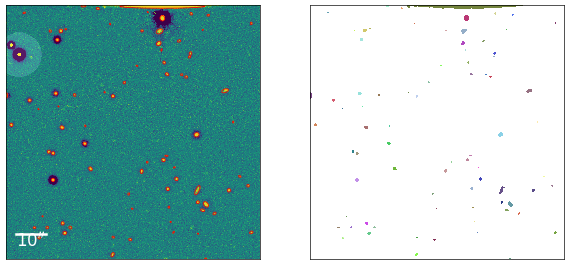

In [16]:
fitter._cpct_obj_detection()

    Detected 41 objects


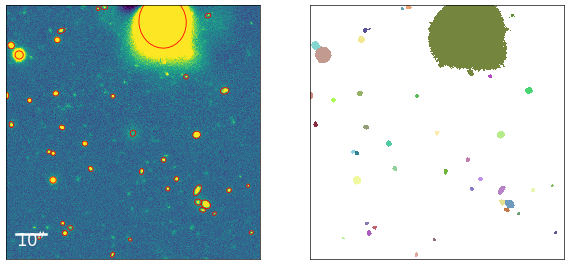

In [17]:
fitter._big_obj_detection()

In [18]:
fitter._merge_catalogs()

In [19]:
fitter._construct_obs_frames()

In [20]:
if fitter.bright:
    fitter.variance = 0.05**2
    fitter.scales = [0, 1, 2, 3, 4, 5, 6]
    fitter.starlet_thresh = 0.5
    fitter.min_grad = 0.02

fitter._add_sources(min_grad=fitter.min_grad, thresh=0.1, bkg=True)

  - Wavelet modeling with the following hyperparameters:
    min_grad = 0.01, starlet_thresh = 0.30 (contam_ratio = 0.03), 
     monotonic = True, variance = 0.00022, scales = [0, 1, 2, 3, 4].
    Total number of sources: 2


[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>]

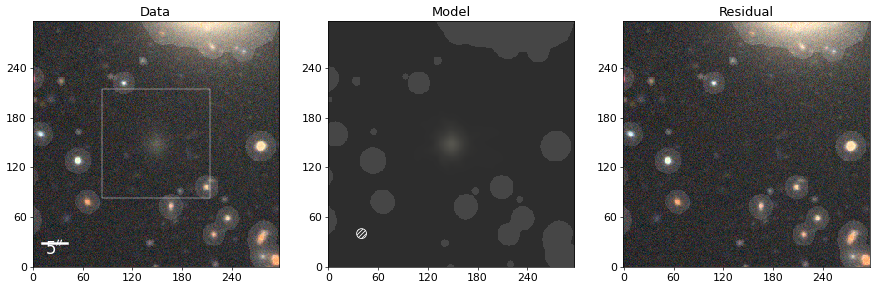

In [22]:
kz.display.display_scarlet_model(
    fitter.blend,
    #show_ind=[0],
    zoomin_size=50,
    minimum=-0.2,
    stretch=1,
    add_boxes=True,
    channels='griz',
    show_mask=False,
    show_mark=False, 
    show_loss=False)

  - Optimizing scarlet model...
    Optimizaiton: Succeed for e_rel = 0.0001 with 76 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 134 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0002 with 167 iterations! Try higher accuracy!
  - After 167 iterations, logL = 810702.08
    Elapsed time for fitting: 49.34 s


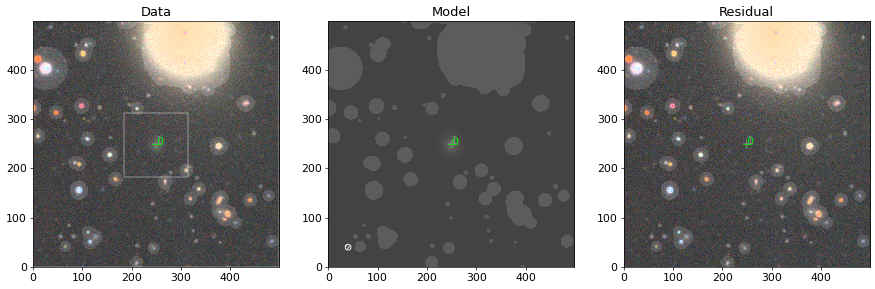

In [23]:
fitter._optimize()

In [29]:
fitter._find_sed_ind()
fitter._gen_final_mask()

  - Components [0] are considered as the target galaxy.
  - Masking stars and other sources that are modeled, to deal with leaky flux issue.
  - Saving the results as /tigress/jiaxuanl/Data/HSC/LSBG/Model/nsa_z002_004/nsa-50509-trained-model-wavelet.df


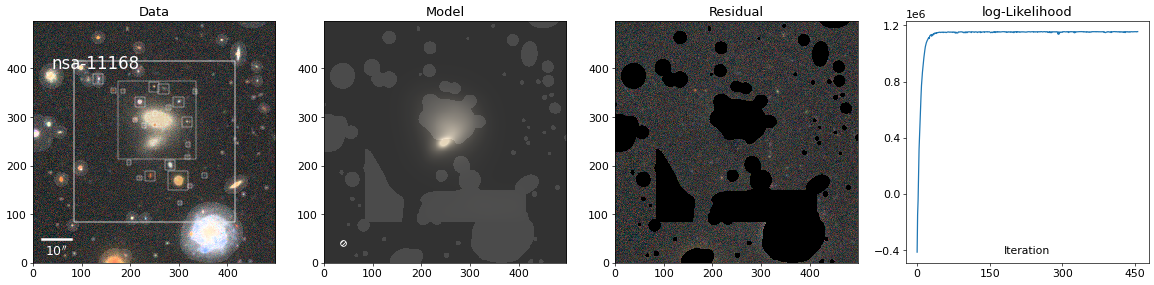

In [21]:
fitter._display_results()

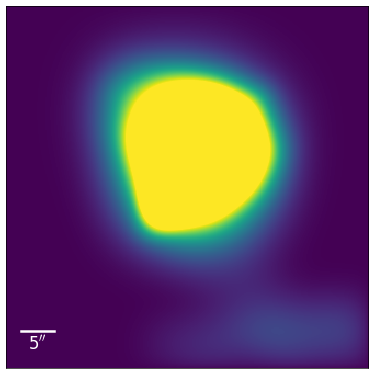

In [22]:
# display_single(s.image, scale='linear');
model = fitter.blend.sources[0].get_model()
display_single(fitter.observation.render(model)[0]);

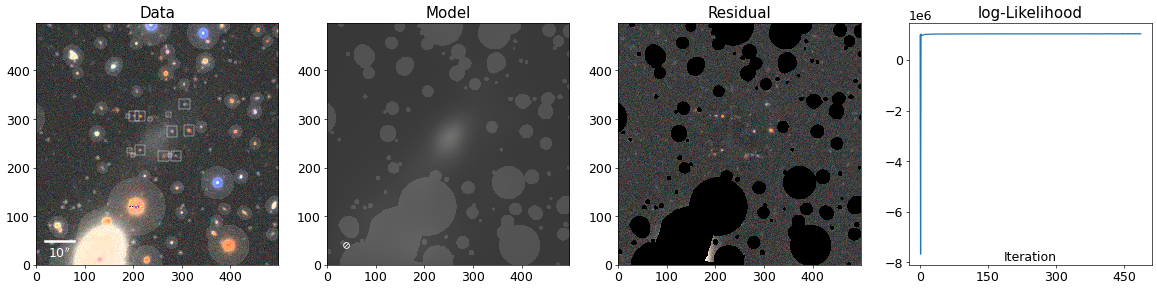

In [12]:
fig = kz.display.display_scarlet_results_tigress(
        fitter._blend,
#         fitter.final_mask,
        show_ind=[0], #fitter.sed_ind,
#         zoomin_size=50,
        minimum=-0.2,
        stretch=0.8,
        Q=1,
        channels=fitter.data.channels,
        show_loss=True,
        show_mask=False,
        show_mark=False,
        scale_bar=True)

In [15]:
from kuaizi.measure import makeMeasurement

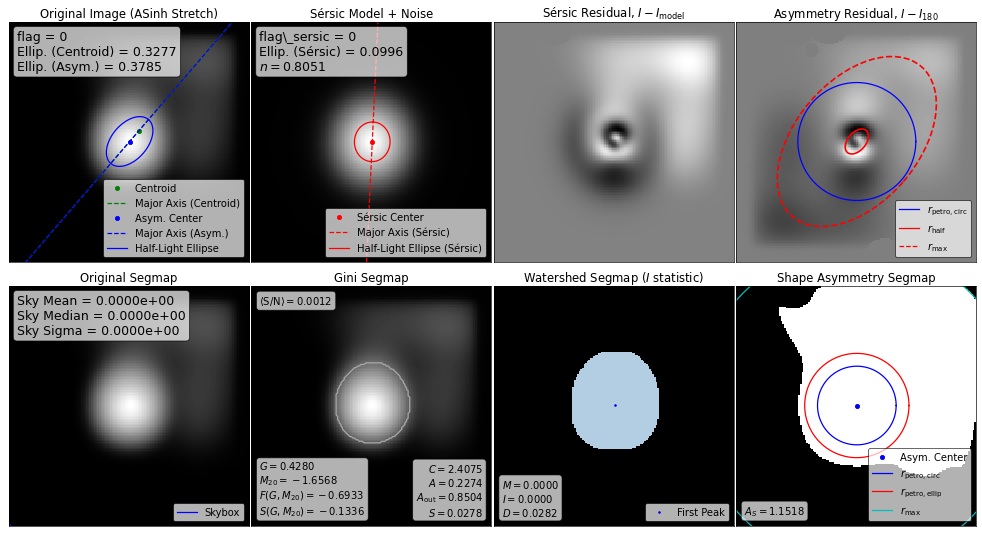

In [21]:
measurement, morph = makeMeasurement(list(np.array(fitter.blend.sources)[[0]]),
                                 fitter.blend.observations[0],
#                                  aggr_mask=fitter.final_mask.astype(bool),
                                 makesegmap=False, sigma=0.02,
                                 zeropoint=27.0, out_prefix=None,
                                 show_fig=True, asinh_a=0.02, framealpha=0.7)

In [18]:
measurement['mag'], measurement['SB_eff_avg']

(array([22.60007 , 22.011074, 21.633987, 21.514553], dtype=float32),
 array([26.344   , 25.755003, 25.377914, 25.25848 ], dtype=float32))

In [22]:
measurement['rhalf_circularized'] * 0.168

2.396249181805254

In [20]:
measurement['sersic_rhalf']

12.362547669660811

In [51]:
lsbg_cat[300:500][['viz-id', 'ra', 'dec']
                 ].write('/tigress/jiaxuanl/public_html/galary/catalogs/test_lsbg.txt', format='ascii')